In [22]:
import argparse
import glob
import json
import os
from torchvision.transforms import transforms
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from collections import Counter
from pytorch_grad_cam import GradCAMPlusPlus
import matplotlib.pyplot as plt
import numpy as np
import torch
import wandb
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import torchvision.transforms.functional as TF
from albumentations import ImageOnlyTransform
from src.utils.transform_utils import load_transforms
from src.models.regnety.regnety import RegNetY

In [23]:
api = wandb.Api()
run = api.run(f'mvrcii_/SEER/5wqhpp88')
config = argparse.Namespace(**run.config)

In [18]:
transforms_str = run.summary.get('transforms')
_, val_transform = load_transforms(img_size=config.img_size, transforms_string=transforms_str)
base_transform = val_transform

In [11]:
# Project paths
vissl_project_dir = 'C:\\Users\Marce\Git-Master\JMU\Masterarbeit\\vissl'
endoscopy_project_dir = 'C:\\Users\Marce\Git-Master\JMU\Masterarbeit\endoscopy'
cvip_project_dir = 'C:\\Users\Marce\Git-Master\Privat\cv2024'

In [12]:
class_mapping_path = os.path.join(endoscopy_project_dir, 'datasets/endoextend_dataset/class_mapping.json')
absolute_path = os.path.abspath(class_mapping_path)
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

In [13]:
ckpt_filename = 'best_epoch01_val_mAP_weighted0.67.ckpt'
ckpt_path = os.path.join(cvip_project_dir, 'pretrained_models', ckpt_filename)

model = RegNetY.load_from_checkpoint(checkpoint_path=ckpt_path, config=config, class_to_idx=class_mapping)
model.to(torch.device('cuda'))
model.eval();

In [14]:
# GradCAM
target_layers = [model.backbone.s4.b1.conv3.conv]
for param in model.backbone.s4.b1.conv3.conv.parameters():
    param.requires_grad = True

grad_cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

In [86]:
class CustomCrop(ImageOnlyTransform):
    def __init__(self, border=10, always_apply=False, p=0.5):
        super(CustomCrop, self).__init__(always_apply=always_apply, p=p)
        self.border = border

    def apply(self, img, **params):
        h, w = img.shape[:2]
        return img[self.border:h - self.border, self.border:w - self.border]

In [24]:
def revert_transformations(tensor):
    """Revert transformations applied during preprocessing, mainly normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor.mul_(std).add_(mean)  # Revert normalization
    return TF.to_pil_image(tensor.cpu())  # Convert to PIL Image for visualization

In [25]:
def load_and_transform_image(image_path, transform):
    with Image.open(image_path) as img:
        return transform(image=np.array(img.convert('RGB')))['image'].to(torch.device('cuda'))

In [26]:
def create_tta_transforms(base_transform, num_variants=5):
    tta_transforms = [base_transform]
    for _ in range(num_variants):
        tta_transform = A.Compose([
            A.OneOf([  
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=10, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ], p=1),  
            base_transform,
        ])
        tta_transforms.append(tta_transform)
    return tta_transforms

In [ ]:
def predict_images_with_tta(model, image_paths, batch_size=32, num_augmentations=5, revert_transform=False):
    """Predict classes for a list of image paths using TTA."""
    final_predictions = []
    image_list = []  # Store tensors for return
    tta_transforms = create_tta_transforms(base_transform, num_augmentations)  # Create TTA transforms

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_predictions = []
        for tta_transform in tta_transforms:
            batch_tensor, tensor_images = load_and_transform_image(batch_paths, tta_transform)
            with torch.no_grad():
                logits = model(batch_tensor)
                preds = logits.argmax(dim=1).cpu().numpy()
                batch_predictions.append(preds)
                if revert_transform:
                    tensor_images = [revert_transformations(tensor) for tensor in tensor_images]
                image_list.extend(tensor_images)
        # Average predictions across TTA for each image
        batch_predictions = np.array(batch_predictions)
        averaged_predictions = np.mean(batch_predictions, axis=0).astype(int)
        final_predictions.extend(averaged_predictions)

    return final_predictions, image_list

In [27]:
def predict_image(model, val_transform, image_path):
    img_tensor = load_and_transform_image(image_path, val_transform)
    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0)).squeeze()
        preds = logits.argmax(dim=0).cpu().numpy()
        probs = torch.softmax(logits, dim=0).detach().cpu().numpy()
        return preds, img_tensor, probs

In [28]:
def list_image_files(path: str, extensions=None) -> list:
    """List all image files in a directory, handling multiple extensions."""
    if extensions is None:
        extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp', '.gif']
    images = []
    for extension in extensions:
        images.extend(glob.glob(os.path.join(path, '**', '*' + extension), recursive=True))
    return images

In [29]:
def idx_to_label(idx, class_mapping):
    return {v: k for k, v in class_mapping.items()}[idx]

In [30]:
# Load all foreign_body images
cvip_imgs = list_image_files('cvip')
ee_imgs = list_image_files('endoextend')

# Identify common filenames
filenames1 = {os.path.basename(path) for path in cvip_imgs}
filenames2 = {os.path.basename(path) for path in ee_imgs}
common_filenames = filenames1.intersection(filenames2)

# Extract common images
cvip_images = [path for path in cvip_imgs if os.path.basename(path) in common_filenames]
ee_images = [path for path in ee_imgs if os.path.basename(path) in common_filenames]

In [31]:
def compare_images(ee_tensor, cvip_tensor):
    print(ee_tensor.shape, cvip_tensor.shape)

    # Ensure both tensors are of the same shape and on the same device
    assert ee_tensor.shape == cvip_tensor.shape, "Input tensors must have the same shape."
    ee_tensor = ee_tensor.to(cvip_tensor.device)

    # Remove the batch dimension if present
    ee_tensor = ee_tensor.squeeze(0)
    cvip_tensor = cvip_tensor.squeeze(0)

    # Convert tensors to numpy arrays for some of the metrics
    ee_image = ee_tensor.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]
    cvip_image = cvip_tensor.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]

    # Calculate an appropriate window size for SSIM
    ssim_value = ssim(ee_image, cvip_image, win_size=7, data_range=np.max(ee_image) - np.min(ee_image),
                      multichannel=True, channel_axis=2)

    # 1. Mean Squared Error (MSE)
    mse = F.mse_loss(ee_tensor, cvip_tensor).item()
    print(f'Mean Squared Error (MSE): {mse}')

    # 2. Peak Signal-to-Noise Ratio (PSNR)
    max_pixel_value = 1.0  # Assuming images are normalized [0, 1]
    mse_tensor = torch.tensor(mse)  # Convert MSE to a tensor
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse_tensor)
    print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr.item()} dB')

    if ssim_value is not None:
        print(f'Structural Similarity Index (SSIM): {ssim_value}')
    else:
        print("SSIM calculation was skipped due to small image dimensions.")

    # 4. Cosine Similarity
    ee_tensor_flat = ee_tensor.flatten()
    cvip_tensor_flat = cvip_tensor.flatten()
    cosine_similarity = F.cosine_similarity(ee_tensor_flat, cvip_tensor_flat, dim=0)
    print(f'Cosine Similarity: {cosine_similarity.item()}')

EndoExtend Probabilities:
 ['0.1290', '0.0096', '0.1142', '0.1452', '0.1172', '0.3123', '0.0269', '0.0932', '0.0346', '0.0178']
CVIP Probabilities:
 ['0.0648', '0.0488', '0.0439', '0.0772', '0.0306', '0.2908', '0.1894', '0.1859', '0.0567', '0.0119']
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
Mean Squared Error (MSE): 0.0005355555331334472
Peak Signal-to-Noise Ratio (PSNR): 32.711952209472656 dB
Structural Similarity Index (SSIM): 0.9243381023406982
Cosine Similarity: 0.9978997111320496


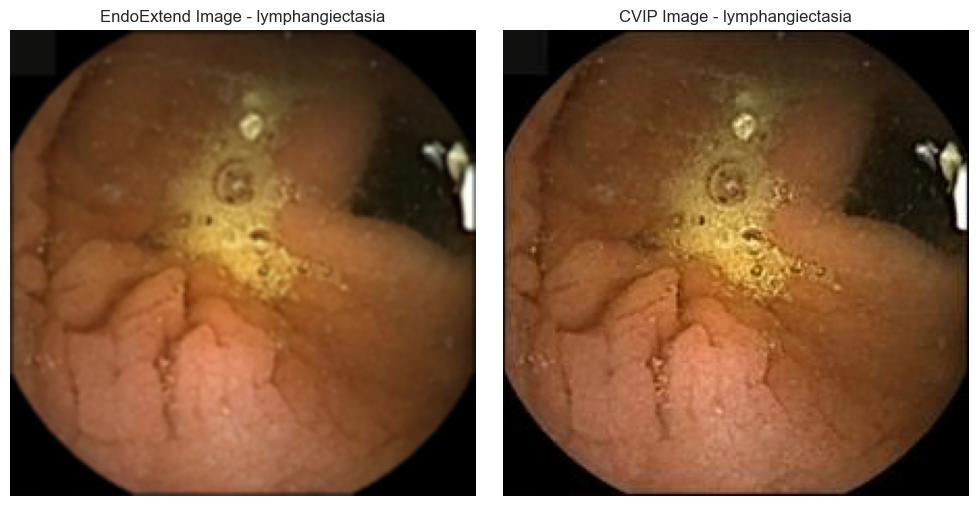

In [33]:
def plot_image_idx(ee_path, cvip_path):
    cvip_pred, cvip_tensor, cvip_probs = predict_image(model=model, image_path=cvip_path,
                                                       val_transform=base_transform)
    ee_pred, ee_tensor, ee_probs = predict_image(model=model, image_path=ee_path,
                                                 val_transform=base_transform)

    print("EndoExtend Probabilities:\n", [f"{p:.4f}" for p in ee_probs])
    print("CVIP Probabilities:\n", [f"{p:.4f}" for p in cvip_probs])

    cvip_img = revert_transformations(cvip_tensor)
    ee_img = revert_transformations(ee_tensor)

    transform = transforms.ToTensor()
    cvip_tensor = transform(cvip_img).unsqueeze(0)
    ee_tensor = transform(ee_img).unsqueeze(0)

    compare_images(cvip_tensor=cvip_tensor, ee_tensor=ee_tensor)

    cvip_pred_label = idx_to_label(cvip_pred.item(), class_mapping)
    ee_pred_label = idx_to_label(ee_pred.item(), class_mapping)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(ee_img)
    axes[0].set_title(f'EndoExtend Image - {ee_pred_label}')  # Include predicted label in title
    axes[0].axis('off')  # Hide axes

    # Display CVIP image with predicted label
    axes[1].imshow(cvip_img)
    axes[1].set_title(f'CVIP Image - {cvip_pred_label}')  # Include predicted label in title
    axes[1].axis('off')  # Hide axes

    # Show the plot
    plt.tight_layout()
    plt.show()


for i in range(0, 1):
    plot_image_idx(ee_path=ee_images[i], cvip_path=cvip_images[i])

In [ ]:
cvip_predictions, _ = predict_images_with_tta(model=model, image_paths=cvip_images, revert_transform=False)
print(Counter(cvip_predictions))

In [ ]:
cvip_predictions, _ = predict_images(model=model, image_paths=cvip_images, val_transform=base_transform,
                                     revert_transform=False)
print(Counter(cvip_predictions))

In [ ]:
ee_predictions, _ = predict_images_with_tta(model=model, image_paths=ee_images[:64], revert_transform=False)
print(Counter(ee_predictions))

In [ ]:
ee_predictions, _ = predict_images(model=model, image_paths=ee_images[:64], val_transform=base_transform,
                                   revert_transform=False)
print(Counter(ee_predictions))